In [1]:
!pip install toolz tqdm keras opencv-python


In [2]:
from __future__ import print_function
from PIL import Image
import numpy as np
import os
import glob


import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload


import cv2

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')

from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize as imresize

from keras.preprocessing.image import img_to_array
from keras.layers import Conv2D, UpSampling2D, InputLayer, MaxPool2D
from keras.models import Sequential
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Data loading

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

We'll use the general idea from [How to colorize black & white photos with just 100 lines of neural network code
](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d) blog post, so we need to define conversion between RGB and LAB colorspaces. 

In [0]:
def rgb2lab(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

def lab2rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

In [6]:
# change this if you want to load your image - make sure it's on your google drive
IMAGE_NAME = 'pkin_caly.jpg' 
IMAGE_PATH = os.path.join('images', IMAGE_NAME)

!mkdir -p images

move_from_drive_to_disk(['pkin_caly.jpg'], IMAGE_PATH)

Downloaded 32489/32489 bytes


We'll try to reconstruct color image from only its luminance (grayscale) channel (L from LAB).

In [7]:
# Get image
image = img_to_array(imread(IMAGE_PATH))
image = np.array(image, dtype='uint8')
image.shape

(371, 556, 3)

In [0]:
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

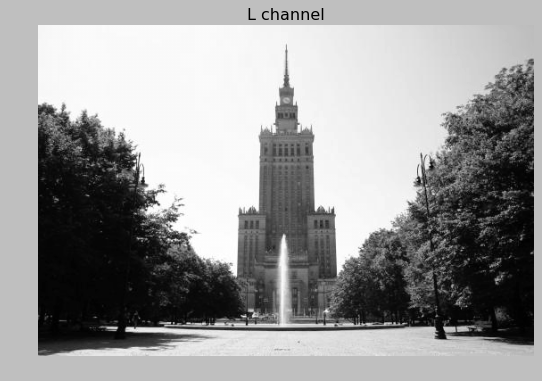

In [9]:
plt.title('L channel')
plt.imshow(image_lab[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Import map images into the lab colorspace
input_shape = (384, 576)

input_image = imresize(rgb2lab(image), input_shape)

X = input_image[:,:,0]
Y = input_image[:, :, 1:]
X = X.reshape((1, *X.shape, 1))
Y = np.expand_dims(Y, 0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:

# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='sigmoid', padding='same'))

# Finish model
model.compile(optimizer=RMSprop(decay=0.05),loss='mse')


In [12]:
%%time
#Train the neural network
model.fit(x=X, y=Y, batch_size=1, epochs=100)
print(model.evaluate(X, Y, batch_size=1))


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0016
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0019
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0014
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0013
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0013
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0013
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0011
Epoch 10/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0013
Epoch 12/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0012
Epoch 13/100
1/1 [==============================] -

Epoch 34/100
1/1 [==============================] - 0s 39ms/step - loss: 6.9602e-04
Epoch 35/100
1/1 [==============================] - 0s 41ms/step - loss: 6.7044e-04
Epoch 36/100
1/1 [==============================] - 0s 41ms/step - loss: 6.8597e-04
Epoch 37/100
1/1 [==============================] - 0s 41ms/step - loss: 6.6034e-04
Epoch 38/100
1/1 [==============================] - 0s 41ms/step - loss: 6.7426e-04
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 6.5116e-04
Epoch 40/100
1/1 [==============================] - 0s 41ms/step - loss: 6.6591e-04
Epoch 41/100
1/1 [==============================] - 0s 40ms/step - loss: 6.4104e-04
Epoch 42/100
1/1 [==============================] - 0s 40ms/step - loss: 6.5150e-04
Epoch 43/100
1/1 [==============================] - 0s 39ms/step - loss: 6.2905e-04
Epoch 44/100
1/1 [==============================] - 0s 41ms/step - loss: 6.3639e-04
Epoch 45/100
1/1 [==============================] - 0s 40ms/step - loss: 6.1

Epoch 68/100
1/1 [==============================] - 0s 44ms/step - loss: 5.4585e-04
Epoch 69/100
1/1 [==============================] - 0s 42ms/step - loss: 5.3681e-04
Epoch 70/100
1/1 [==============================] - 0s 42ms/step - loss: 5.4764e-04
Epoch 71/100
1/1 [==============================] - 0s 44ms/step - loss: 5.4104e-04
Epoch 72/100
1/1 [==============================] - 0s 48ms/step - loss: 5.5012e-04
Epoch 73/100
1/1 [==============================] - 0s 42ms/step - loss: 5.3576e-04
Epoch 74/100
1/1 [==============================] - 0s 42ms/step - loss: 5.3741e-04
Epoch 75/100
1/1 [==============================] - 0s 45ms/step - loss: 5.2512e-04
Epoch 76/100
1/1 [==============================] - 0s 47ms/step - loss: 5.2671e-04
Epoch 77/100
1/1 [==============================] - 0s 44ms/step - loss: 5.1679e-04
Epoch 78/100
1/1 [==============================] - 0s 42ms/step - loss: 5.1822e-04
Epoch 79/100
1/1 [==============================] - 0s 45ms/step - loss: 5.1

In [13]:
# Output colorizations
output = model.predict(X)

canvas = np.concatenate([X, output], axis=-1)[0]
canvas.shape

(384, 576, 3)

In [0]:
retrieved_image = lab2rgb(np.array(canvas * 255, dtype='uint8'))

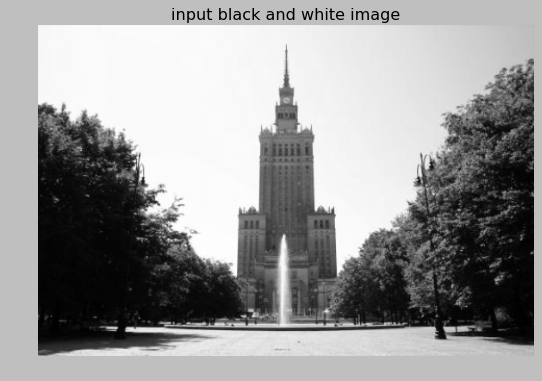

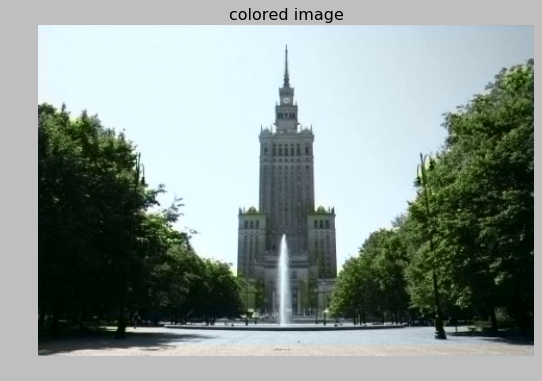

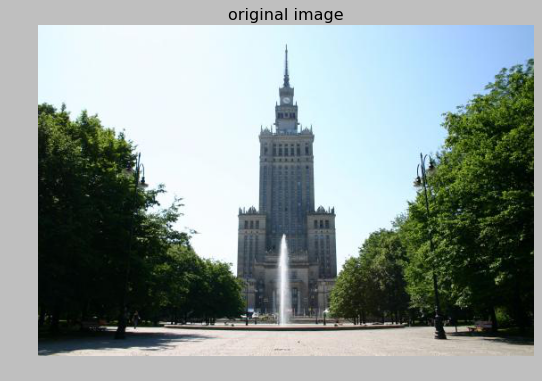

In [15]:
plt.title('input black and white image')
plt.imshow(X[0][:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

plt.title('colored image')
plt.imshow(retrieved_image)
plt.axis('off')
plt.show()


plt.title('original image')
plt.imshow(image)
plt.axis('off')
plt.show()